# `F = ma`

With a simple linear operation (sans-activation). This is obviously an impossible feat (to achieve 0 error on) with a linear operation, but we might learn something from the process.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

## Model

Keeping this extremely simple

In [2]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer = LinearLayer(2, 1, use_act=use_act)

    def forward(self, x):
        return self.layer(x)

## Data

Also keeping this extremely simple

In [3]:
X = torch.rand(10000, 2)  # mass and acceleration respectively
Y = X[:, 0] * X[:, 1]  # force = mass * acceleration
Y = Y[:, None]
X.shape, Y.shape

(torch.Size([10000, 2]), torch.Size([10000, 1]))

In [4]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 2]),
 torch.Size([8000, 1]),
 torch.Size([2000, 2]),
 torch.Size([2000, 1]))

## Training

I'll just do full gradient descent to keep things simple.

In [5]:
N = 100  # number of epochs

model = Net(use_act=False)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-1)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/100 [00:00<?, ?it/s]

## Results

In [6]:
def plot_loss(train_loss, valid_loss):
    _, ax = plt.subplots()

    ax.plot(train_loss, label="train")
    ax.plot(valid_loss, label="valid")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend()


def get_preds(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.flatten().numpy()
    y_targs = Y_valid.flatten().numpy()

    return y_preds, y_targs


def get_valid_loss(model):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    return loss_func(out, Y_valid)


def plot_results(y_preds, y_targs):
    _, ax = plt.subplots()

    ax.scatter(y_preds, y_targs, s=4, label="predictions")
    ax.plot(y_targs, y_targs, color="salmon", ls="--", lw=0.5, label="perfect accuracy")
    ax.set(xlabel="y_preds", ylabel="y_targs")
    ax.legend()

Did a bit of HP tuning to get to this thing which looks like it's converged. Looks funky though 🤔

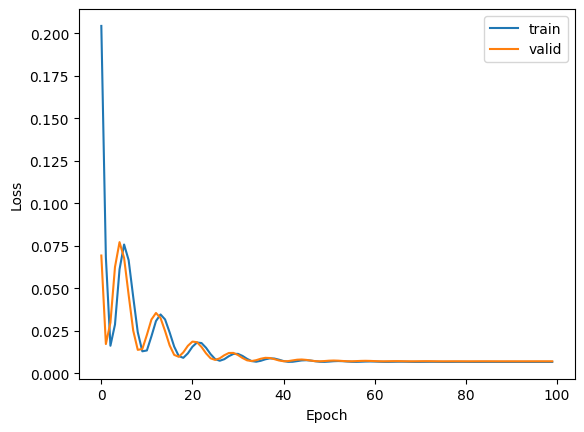

In [7]:
plot_loss(df["train_loss"], df["valid_loss"])

In [8]:
get_valid_loss(model)

tensor(0.0072)

In [9]:
y_preds, y_targs = get_preds(model)

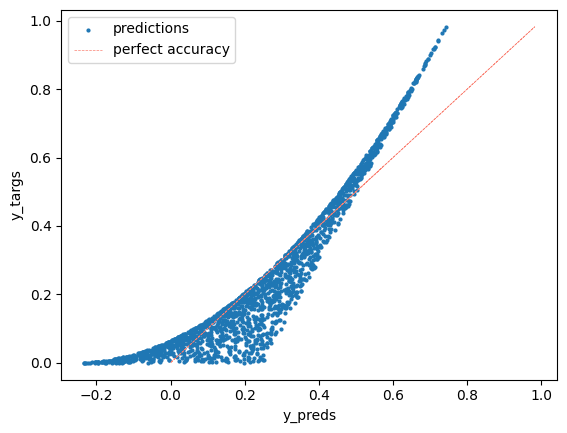

In [10]:
plot_results(y_preds, y_targs)

Ok it looks half decent. Let's have a look now at the layers to see if it makes sense.

## Introspection

In [11]:
model

Net(
  (layer): LinearLayer(
    (linear): Linear(in_features=2, out_features=1, bias=True)
    (act): ReLU()
  )
)

In [12]:
W, b = list(model.layer.linear.parameters())
W, b

(Parameter containing:
 tensor([[0.5037, 0.5037]], requires_grad=True),
 Parameter containing:
 tensor([-0.2558], requires_grad=True))

In [13]:
def get_preds_range(x2=0.5):
    # True solution
    x1 = np.linspace(0, 1, 50)
    x2 = np.repeat(x2, 50)
    y = x1 * x2

    # Predicted solution
    with torch.inference_mode():
        x = torch.stack([torch.as_tensor(x1), torch.as_tensor(x2)]).T.float()
        y_hat = model(x)
        y_hat = y_hat.detach().numpy()

    return y_hat, y


def get_preds_multi_range():
    x2s = np.linspace(0, 1, 11)
    rows = []
    for x2 in x2s:
        row = {"x2": x2}
        row["y_hat"], row["y"] = get_preds_range(x2=x2)
        rows.append(row)
    return rows

In [14]:
results = get_preds_multi_range()

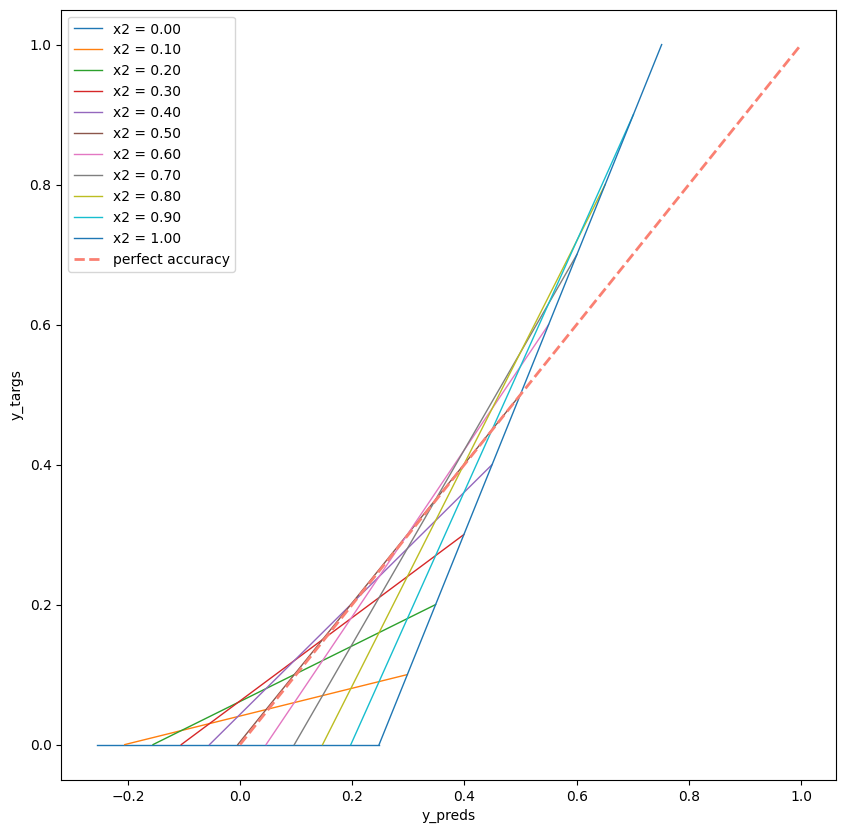

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))

for row in results:
    ax.plot(row["y_hat"], row["y"], lw=1, label=f"x2 = {row['x2']:.2f}")

ax.plot([0, 1], [0, 1], color="salmon", lw=2, ls="--", label="perfect accuracy")
ax.set(xlabel="y_preds", ylabel="y_targs")
ax.legend()

(array([1945., 1203.,  960.,  767.,  676.,  558.,  435.,  372.,  303.,
         248.,  201.,  128.,  127.,   51.,   26.]),
 array([5.77285027e-06, 6.55666888e-02, 1.31127611e-01, 1.96688533e-01,
        2.62249440e-01, 3.27810347e-01, 3.93371284e-01, 4.58932191e-01,
        5.24493098e-01, 5.90054035e-01, 6.55614972e-01, 7.21175849e-01,
        7.86736786e-01, 8.52297723e-01, 9.17858601e-01, 9.83419538e-01]),
 <BarContainer object of 15 artists>)

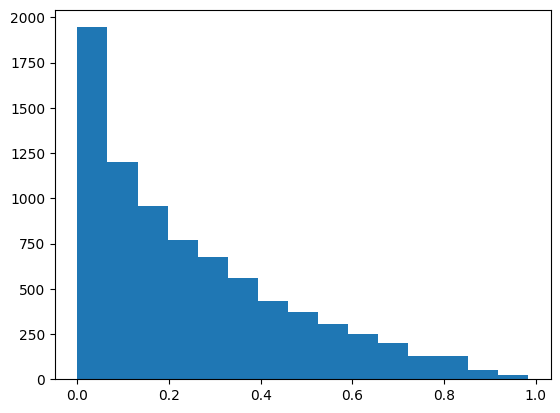

In [16]:
plt.hist(Y_train.flatten(), bins=15)

## Analytical optimal solution

Since I don't yet have a non-linearity, I can hopefully find an analytical optimum set of values for $w_1$, $w_2$ and $b$ (after I switched to the differentiable MSE Loss as opposed to L1Loss!).

This turns out to be quite a nasty integral to evaluate so I'm going to skip it for now.

A simpler route we can find looking at the error, $\epsilon$, before the application of MSE:

$\epsilon = w_1 x_1 + w_2 x_2 - b - x_1 x_2$

and then once we've integrated over the uniformly distributed $x_1$ and $x_2$, we get the expected value:

$\bar{\epsilon} = \frac{w_1}{2} + \frac{w_2}{2} - b - \frac{1}{4}$

If setting this equal to 0 (which is when I'd expect the MSE to also be equal to zero, intuitively), then we can see that our final results for $w_1 = \frac{1}{2}$, $w_2 = \frac{1}{2}$ and $b = \frac{1}{4}$ represent at least one (amongst many) solution(s) to minimising $\bar{\epsilon}$.

There's probably an interesting reason why they end up at nice round numbers instead of some other solution that would be good to work out. However, this has made me confident enough that the result makes sense.

I would still like to return to do the full calculation with MSE loss. This might be the last place I can find analytical solutions.